In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint


In [8]:
df = pd.read_csv('GROUP7/b37b-brfu_clean.tsv',sep='\t')

In [9]:
coords = df.as_matrix(columns=['comparable_rental_2_address/latitude', 'comparable_rental_2_address/longitude'])

In [13]:
coords.shape

(18, 2)

In [26]:
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

In [27]:
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 8


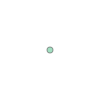

In [31]:
MultiPoint(clusters[7]).centroid

In [32]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [33]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [35]:
rs = rep_points.apply(lambda row: df[(df['comparable_rental_2_address/latitude']==row['lat']) & (df['comparable_rental_2_address/longitude']==row['lon'])].iloc[0], axis=1)

In [37]:
rs

,comparable_rental_2_address/latitude,comparable_rental_2_address/human_address/address,comparable_rental_2_address/human_address/city,comparable_rental_2_address/human_address/state,comparable_rental_2_address/longitude,comparable_rental_1_neighborhood,staten_island_cooperatives_comparable_properties_year_built,staten_island_cooperatives_comparable_properties_building_classification,comparable_rental_2_gross_sqft,comparable_rental_2_building_classification,...,comparable_rental_1_est_gross_income,comparable_rental_1_gross_sqft,staten_island_cooperatives_comparable_properties_address/latitude,staten_island_cooperatives_comparable_properties_address/human_address/address,staten_island_cooperatives_comparable_properties_address/human_address/city,staten_island_cooperatives_comparable_properties_address/human_address/state,staten_island_cooperatives_comparable_properties_address/longitude,staten_island_cooperatives_comparable_properties_full_market_value,comparable_rental_2_market_value_per_sqft,comparable_rental_1_year_built
0,40.606004,1950 CLOVE ROAD,Staten Island,NY,-74.086615,NEW BRIGHTON,1984,D0-ELEVATOR,180495,D1-ELEVATOR,...,2840710,174895,40.638186,10 BAY STREET LANDING,Staten Island,NY,-74.073338,5060000,22.22,1963
1,40.636779,137 HEBERTON AVENUE,Staten Island,NY,-74.131313,NEW BRIGHTON,1985,D4-ELEVATOR,20800,C1-WALK-UP,...,162383,13644,40.639293,44 BAY STREET LANDING,Staten Island,NY,-74.073321,741000,51.00,1920
2,40.643589,100 STUYVESANT PLACE,Staten Island,NY,-74.077428,NEW BRIGHTON-ST. GEORGE,1960,D4-ELEVATOR,121000,D7-ELEVATOR,...,4290687,524513,40.606674,350 RICHMOND TERRACE,Staten Island,NY,-74.162401,4050000,22.56,1976
3,40.636153,330 BARD AVENUE,Staten Island,NY,-74.106852,TOMPKINSVILLE,1950,C6-WALK-UP,10086,C9-WALK-UP,...,142552,17320,40.634212,515 CASTLETON AVENUE,Staten Island,NY,-74.099836,240000,22.70,1931
4,40.616992,446 WATCHOGUE ROAD,Staten Island,NY,-74.146053,WESTERLEIGH,1968,C6-WALK-UP,9928,C1-WALK-UP,...,122719,9960,40.631743,255 FOREST AVENUE,Staten Island,NY,-74.098079,337000,34.00,1980
5,40.606674,832 POST AVENUE,Staten Island,NY,-74.162401,WEST NEW BRIGHTON,1968,C6-WALK-UP,8720,C1-WALK-UP,...,245856,15888,40.631830,245 FOREST AVENUE,Staten Island,NY,-74.097800,503000,53.00,1941
6,40.510718,7352 AMBOY ROAD,Staten Island,NY,-74.242121,ELTINGVILLE,1999,C6-WALK-UP,11400,C9-WALK-UP,...,205136,23645,40.612546,361 SKYLINE DRIVE,Staten Island,NY,-74.080054,507000,40.50,1991
7,40.558380,7 BENTON COURT,Staten Island,NY,-74.136561,GREAT KILLS,1977,C6-WALK-UP,25420,C9-WALK-UP,...,265658,19200,40.556922,3482 AMBOY ROAD,Staten Island,NY,-74.138832,2640000,26.60,1973


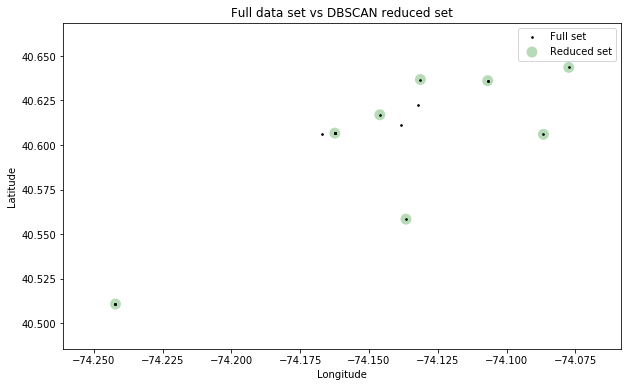

In [38]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['comparable_rental_2_address/longitude'], rs['comparable_rental_2_address/latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['comparable_rental_2_address/longitude'], df['comparable_rental_2_address/latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()
